In [1]:
using Distributed

In [2]:
workers()

1-element Vector{Int64}:
 1

In [3]:
addprocs(30)
;

In [4]:
nworkers()

30

In [5]:
@everywhere using FastaIO
@everywhere using MultivariateStats
@everywhere using LinearAlgebra
@everywhere using DelimitedFiles
@everywhere using StatsBase
@everywhere using DCAUtils
@everywhere using PyPlot
@everywhere using Random
@everywhere using Printf
@everywhere using LinearAlgebra
@everywhere using GLM
@everywhere using Statistics
@everywhere using KitMSA

In [6]:
@everywhere include("../src/read_write.jl")
@everywhere include("../src/energy.jl")
@everywhere include("../src/msa_tools.jl")
@everywhere include("../src/extra_tools.jl")

In [7]:


function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

function dna_seq2amino_seq(seq_dna)
    new = []
    for a in seq_dna
        push!(new, cod2amino[a])
    end
    return new
end

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end


function eliminate(msa, tresh, idx)
    L = length(msa[idx,:])
    trimmed_msa = []
    for i in 1:length(msa[:,1])
        d = KitMSA.my_hamming(msa[idx,:], msa[i,:])
        if  d > L*tresh
            push!(trimmed_msa, msa[i,:])
        end
    end
    push!(trimmed_msa, msa[idx,:])
    return hcat(trimmed_msa...)'
end


function reweighting(msa, tresh)
    final_msa =[]
    new_msa = deepcopy(msa)
    a = 0
    for i in 1:20000
        new_msa = eliminate(new_msa, tresh, 1)
    end    
    println(length(new_msa[:,1]))
    return new_msa
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

plot_pca (generic function with 1 method)

In [8]:
@everywhere function Delta_energy(h::Array{Float64,2}, J::Array{Float64,4}, 
        S::Array{<:Integer,1}, ref::Array{<:Integer, 1})
    q, N = size(h)
    E = 0.0
    
    index_v = collect(1:N)
    common = (S .== ref)
    idx = findfirst(isequal(false), common)
    common = index_v[common]
    #println(idx)
    #println(common)
    E -= (h[S[idx],idx] - h[ref[idx],idx])
    @fastmath for j = 1:N
        if j > idx
            @inbounds  E -= (J[S[j],S[idx],j,idx] - J[ref[j],ref[idx],j,idx] )
        end
    end
    
    @fastmath for i in common
        if idx > i
            @inbounds  E -= (J[S[idx],S[i],idx,i] - J[ref[idx],ref[i],idx,i] )
        end
    end
    
    return E
end


In [9]:
@everywhere function get_accessible_nucleo_muts_metro_DNA_det_bal(old_cod)
    if old_cod .== "---"
        amino_list = [i for i in 1:21]
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        codon_list = filter!(aa->aa != old_cod, codon_list)
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    end
    
    old_codon = [string(old_cod[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 12)
    
    for i in 1:3
        new_codon = deepcopy(old_codon)
        for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
            new_codon[i] = nucl
            codon_list[(i-1)*4 + j] = join(new_codon)
        end
    end
    
    push!(codon_list, "---")
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	amino_list = unique!(filter!(aa->aa != 21, amino_list))

    #codon_list = filter!(aa->aa != "TAA", codon_list)
    #codon_list = filter!(aa->aa != "TAG", codon_list)
    #codon_list = filter!(aa->aa != "TGA", codon_list)
    codon_list = filter!(aa->aa != old_cod, codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end


@everywhere function get_accessible_nucleo_for_del_ins(old_cod)

    if old_cod .== "---"
        amino_list = [i for i in 0:20]
        amino_list[1] = 21
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        #push!(codon_list, old_cod )
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    else
        codon_list = ["---"]
        push!(codon_list, old_cod)
        amino_list = get.(Ref(cod2amino), codon_list, 0)
        #println(amino_list)
        return amino_list, codon_list
    end
end
   

In [33]:
@everywhere mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

@everywhere function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

@everywhere function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        result += J[mutated_seq[i], q_k ,i, k]
    end
    return result
end 

@everywhere function nucleo_cond_proba_DNA_gibbs(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
    #println(q)
    #println(codon_list)
	@inbounds for (index, codon_k) in enumerate(codon_list)
        #println(index)
        q_k = q[index]
        #println(q_k)
        log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
        log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
		prob[index] = exp(log_proba/T)
	end
	return normalize(prob,1)
end



@everywhere function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,codon_usage::Dict{String, Float64},T = 1)
    
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end


@everywhere function square_array(arr)
    squares = Dict()
    result = similar(arr)
    for i in 1:length(arr)
        if haskey(squares, arr[i])
            result[i] = squares[arr[i]]
            println("not computed")
        else
            square = arr[i]^2
            squares[arr[i]] = square
            result[i] = square
            println("computed")
        end
    end
    return result
end



@everywhere function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, codon_usage::Dict{String, Float64}, T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
            #println("not computed")
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, codon_usage, T)
            d[q_k] = log_proba
            #println("computed")
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

In [11]:
# Manually create the dictionary with codon frequencies for e coli
@everywhere codon_usage = Dict(
    "TTT" => 0.58, "TTC" => 0.42,
    "TTA" => 0.14, "TTG" => 0.13,
    "TCT" => 0.17, "TCC" => 0.15, "TCA" => 0.14, "TCG" => 0.14,
    "TAT" => 0.59, "TAC" => 0.41,
    "TGT" => 0.46, "TGC" => 0.54, "TGG" => 1.00,
    "CTT" => 0.12, "CTC" => 0.10, "CTA" => 0.04, "CTG" => 0.47,
    "CCT" => 0.18, "CCC" => 0.13, "CCA" => 0.20, "CCG" => 0.49,
    "CAT" => 0.57, "CAC" => 0.43,
    "CAA" => 0.34, "CAG" => 0.66,
    "CGT" => 0.36, "CGC" => 0.36, "CGA" => 0.07, "CGG" => 0.1,
    "ATT" => 0.50, "ATC" => 0.39, "ATA" => 0.11,
    "ACT" => 0.19, "ACC" => 0.40, "ACA" => 0.16, "ACG" => 0.25,
    "AAT" => 0.49, "AAC" => 0.51,
    "AAA" => 0.74, "AAG" => 0.26,
    "AGT" => 0.16, "AGC" => 0.24, "AGA" => 0.07, "AGG" => 0.04,
    "GTT" => 0.28, "GTC" => 0.20, "GTA" => 0.17, "GTG" => 0.35,
    "GCT" => 0.18, "GCC" => 0.26, "GCA" => 0.23, "GCG" => 0.33,
    "GAT" => 0.63, "GAC" => 0.37,
    "GAA" => 0.68, "GAG" => 0.32, "ATG" => 1.00,
    "GGT" => 0.35, "GGC" => 0.37, "GGA" => 0.13, "GGG" => 0.15, "---" => 1.
)

;

In [12]:
@everywhere function log_p_codbias(mutated_seq, q_k, k, cod_k, J::Array{Float64,4}, N::Integer,codon_usage::Dict{String, Float64}, T = 1)
    log_proba = h[q_k, k]+T*log(codon_usage[cod_k])
    log_proba += sum_couplings_inbounds(mutated_seq.Amino, q_k, k, J, N)
    return log_proba  
end


@everywhere function nucleo_cond_proba_DNA_gibbs_codbias(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, codon_usage::Dict{String, Float64}, T = 1)
	prob = zeros(length(codon_list))
        
    
	@inbounds for (index, q_k) in enumerate(q)
        log_proba = log_p_codbias(mutated_seq, q_k, k, codon_list[index], J, N, codon_usage, T)
        prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end


@everywhere function gibbs_step_cod_bias(mutated_seq, non_gapped_pos, h, J, N, T, codon_usage::Dict{String, Float64})

    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
        
    new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_codbias(pos_mut, amino_list, codon_list, mutated_seq, h, J, N,codon_usage, T)))
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     

In [30]:
@everywhere function del_ins_codon_sampling(arr)
    n = length(arr)
    beta = 1/64
    alpha = 1-64*beta
    gamma = 1-beta
    if n==2
        probabilities = [beta, gamma]
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    else 
        probabilities = fill(beta, n)
        probabilities[1] = alpha
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    end
end
    
#arr = [5,10]
#sampled_elements = [del_ins_codon_sampling(arr) for i in 1:6400]
#histogram(sampled_elements)
    
@everywhere function gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T, codon_usage::Dict{String, Float64})
    #println("doing gibbs step")
    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, codon_usage, T)))
    end
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     


@everywhere function metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing metropolis insertion/deletion step")
        
    pos_mut = rand(1:length(mutated_seq.Amino))

	old_codon = mutated_seq.DNA[pos_mut]
    old_amino = mutated_seq.Amino[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
    amino_list, codon_list = get_accessible_nucleo_for_del_ins(old_codon)
    #println("Accessible codons (step $steps ) : $(codon_list)")
        
    new_codon = del_ins_codon_sampling(codon_list)
    
    #println("Proposed codon (step $steps ) : $(new_codon)")
    
    if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"  || new_codon == old_codon
        
    else
        new_amino = cod2amino[new_codon]  
        new_sequence = deepcopy(mutated_seq.Amino)
        new_sequence[pos_mut] = new_amino
        deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
        accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
        if rand() < accept_proba
            aa = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = aa
            #acceptance += 1
        end
    end
    return mutated_seq
end


@everywhere function parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino::AbstractString, dir_dna::AbstractString, 
                        sampler_type::AbstractString, wt_name::AbstractString, ref_seq, MC_steps::Integer, h::Array{Float64,2}, 
                        J::Array{Float64,4}, N::Integer, chain_num::Integer, each_step,codon_usage::Dict{String, Float64},
                        codon_bias = true, T = 1.)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    
    mutated_seq = deepcopy(ref_seq[chain_num])
    if chain_num %40000 == 0
        println("p = $(p)")
    end
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
     
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end     
    
    if codon_bias == true
        func = gibbs_step_cod_bias
    else 
        func = gibbs_step
    end
        
    
    @inbounds for steps in 1: MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = func(mutated_seq, non_gapped_pos, h, J, N, T, codon_usage)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
        end  
        
        if steps % each_step == 0
        #if steps > -100
            #println("chain $(chain_num) writing")
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
                    
end

In [14]:
@everywhere function sample_codons(arr)
    n = length(arr)
    probabilities = fill(7/64, n)
    probabilities[end] = 1/64
    index = sample(1:n, Weights(probabilities))
    return arr[index]
end

#arr = [1, 2, 3, 4,5,6,7,8,9,10]

#sampled_elements = [sample_codons(arr) for i in 1:640000]

#histogram(sampled_elements, bins = 10)


In [15]:
PATH_PAR_beta = "../../scra_data_beta/Parameters_conv_Matteo_pc.dat"
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
PATH_PAR_dbd_dec = "../../scra_data_beta/Parameters_conv_decDBD0.98.dat"

"../../scra_data_beta/Parameters_conv_decDBD0.98.dat"

In [17]:
#load fields
h, J = KitMSA.extract_params(PATH_PAR_beta;q=21)
maximum(J)

1.199017

In [16]:
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)

1.959042

In [19]:

#define paths
path_wt_tem = "../data/alignments/refs/TEM1_pfam_DNA.fasta"
path_wt_pse = "../data/alignments/refs/PSE1_pfam_DNA.fasta"

#load wt
wt_tem = join(readdlm(path_wt_tem, skipstart = 1))
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))


#transform wt_dna in amino
L_tem = Int64(length(wt_tem)/3)
tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 1:L_tem]
tem_amino_seq = [cod2amino[codon] for codon in tem_DNA_seq]
seed_seq_tem = SeqToEvolve(tem_amino_seq, tem_DNA_seq)

L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
seed_seq_pse = SeqToEvolve(pse_amino_seq, pse_DNA_seq)
;

## Parallel Run

In [17]:
#nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"))
nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
;

In [39]:
#steps = 256 #pse
#steps = 220 #tem
steps = 1+10^6
#steps = 6*10^7

each_step = 10^4

codon_bias = false
#T = 1.4 #pse experiment
#T = 1.14 #tem experiment
T = 1.0 #natural
#sampler_type = "gibbs"
#sampler_type = "metro"
sampler_type = "mixed"
#nseq = 1:34431 #tem
#nseq = 1:456871 #pse
nseq = 1:1000
#wt_name = "dbd"
#wt_name = "pse"
wt_name = "dbd_random"
#wt_name = "pse_global"
#wt_name = "tem"
N = length(nat_MSA[1,:])
#c = filter_alignment(nseq[end], nat_MSA)
#seed_seq = [SeqToEvolve(c[i,:], amino_seq2dna_seq(c[i,:])) for i in 1:length(c[:,1])]
#seed_seq = [SeqToEvolve(nat_MSA[100,:] , amino_seq2dna_seq(nat_MSA[100,:])) for i in 1:nseq[end]] #dbd
#seed_seq = [seed_seq_pse for i in 1:nseq[end]]
#seed_seq = [seed_seq_tem for i in 1:nseq[end]]

#dbd thornton anc
dbd_sample_AA = [2, 10, 18, 2, 6, 3, 15, 1, 16, 6, 20, 7, 20, 6, 18, 10, 16, 2, 4, 6, 2, 9, 1, 5, 5, 9, 15, 16, 8, 14, 6, 16, 18, 4, 20, 17, 2, 13, 1, 17, 12, 4, 2, 9, 8, 3, 9, 7, 15, 15, 9, 16, 2, 14, 1, 2, 15, 10, 14, 9, 2, 5, 4, 18, 6, 11, 11, 9, 4, 6, 18, 15, 9, 3, 15, 12]


start_wt = dbd_sample_AA
seed_seq = [SeqToEvolve(start_wt , amino_seq2dna_seq(start_wt)) for i in 1:nseq[end]] #beta

p=0.5
;

In [40]:
dir_amino = "../../scra_data_beta/cod_bias$(codon_bias)_amino_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
dir_dna = "../../scra_data_beta/cod_bias$(codon_bias)_dna_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
mkdir(dir_amino)
mkdir(dir_dna)


"../../scra_data_beta/cod_biasfalse_dna_mixed_dbd_random_steps1000001_seqs1000_T1.0p0.5"

In [34]:
@everywhere function parallelo_evol_run(i) 
    if sampler_type == "mixed"
        parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino, dir_dna, 
            sampler_type, wt_name, seed_seq, steps, h, J, N, i, each_step, codon_usage, codon_bias, T)
        if i%100 == 0
            println(i)
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
end

In [21]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, 
        wt_name, seed_seq, steps, h, J, T, amino2cod, cod2amino, codon_usage, codon_bias, N)
    #println("fetched")
end
;

In [42]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type,codon_usage, codon_bias, T, N, seed_seq, steps)
    #println("fetched")
end
;


In [43]:
start=time()
pmap(parallelo_evol_run, nseq)
fine=time()
println(fine-start)
println("MSAs GENERATED!!")

      From worker 13:	100
      From worker 8:	200
      From worker 7:	300
      From worker 13:	400
      From worker 25:	500
      From worker 2:	600
      From worker 6:	700
      From worker 25:	800
      From worker 28:	900
      From worker 21:	1000
350.22678804397583
MSAs GENERATED!!


## CODON BIAS ANALYSIS

In [24]:
function codon_frequency_msa(msa, cod2amino)
    # Create a dictionary to store the frequencies
    codon_freqs = Dict{String, Float64}(key => 0. for key in keys(cod2amino))
    M,L = size(msa)
    for m in 1:M 
        for i in 1:L
            codon_freqs[msa[m,i]] += 1
        end
    end
        
    return codon_freqs
end

function get_codon_bias(msa, cod2amino)
    cod_f = codon_frequency_msa(msa, cod2amino);
    res = zeros(21)
    for i in 1:21
        list = amino2cod[i]
        deg = length(list)
        f = zeros(deg)
        count = sum([cod_f[x] for x in amino2cod[i]])
        idx = 1
        for x in list
            cod_f[x] /= count
            f[idx] = cod_f[x] 
            idx += 1
        end
        eff_cod = 2^(entropy(f,2))
        res[i] = (eff_cod - deg)/deg
    end
    return res, cod_f
end
        

get_codon_bias (generic function with 1 method)

In [47]:
folder_path = "../../scra_data_beta/cod_biasfalse_dna_mixed_dbd_random_steps1000001_seqs1000_T1.0p0.5"

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matr_dna = [read_DNA(joinpath(folder_path, file))
    for file in fasta_files[1:1000]]
@time step_matrices = build_dna_seq_steps(matr_dna);

  1.899702 seconds (8.83 M allocations: 403.972 MiB, 64.97% gc time, 1.19% compilation time)
  0.177455 seconds (101.21 k allocations: 123.298 MiB)


In [27]:
for i in 1:101
    res, cod_f = get_codon_bias(step_matrices[i], cod2amino);
    println((mean(res), std(res)))
end


(-0.16861777241190207, 0.15878708096623065)
(-0.1322883818741047, 0.12013890261714448)
(-0.10944128940846179, 0.09962837064213723)
(-0.09042803891750692, 0.08170101732747546)
(-0.07520088167249638, 0.06880895978561727)
(-0.06349400428792358, 0.059066250478716095)
(-0.053564072374900164, 0.04961366387523451)
(-0.04530125900985051, 0.04149910865121737)
(-0.038071546385092005, 0.03503605570782329)
(-0.0320669020675829, 0.029919498434843612)
(-0.027278469495391994, 0.025394440787442057)
(-0.023069343121560844, 0.02170114049817492)
(-0.01978602881186357, 0.018802686781945844)
(-0.01687329607763934, 0.016126922380134027)
(-0.01435362697416497, 0.013633636152255785)
(-0.012088187780853642, 0.011719381247570356)
(-0.010512357821466681, 0.01017139139221392)
(-0.008670017966854713, 0.008659863771722766)
(-0.007577326693272811, 0.007805267421329183)
(-0.006464669067699703, 0.006893096538167154)
(-0.005436288761172874, 0.0059864364716215165)
(-0.004987963422302607, 0.005393333283027078)
(-0.004649

In [25]:
folder_path_cb = "../../scra_data_beta/cod_bias_dna_mixed_dbd_random_steps1000000_seqs1000_T1.0p0.5/"

fasta_files_cb = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path_cb));
@time matr_dna_cb = [read_DNA(joinpath(folder_path_cb, file))
    for file in fasta_files_cb]
@time step_matrices_cb = build_dna_seq_steps(matr_dna_cb);

 13.904007 seconds (8.96 M allocations: 412.700 MiB, 0.82% compilation time)
  0.169674 seconds (101.21 k allocations: 123.298 MiB)


In [29]:
for i in 1:101
    res, cod_f = get_codon_bias(step_matrices_cb[i], cod2amino);
    #println((mean(res), std(res)))
end


(-0.16861777241190207, 0.15878708096623065)
(-0.136414289053363, 0.1244716012576553)
(-0.11504015609109124, 0.1020014246628419)
(-0.09937181936319743, 0.08568978705013526)
(-0.08774964586537633, 0.07435461647524512)
(-0.07995759114380803, 0.06691487788840558)
(-0.07290539543886372, 0.05997919260561447)
(-0.06795212106110508, 0.055797665446715126)
(-0.06394185716743753, 0.052925114002626866)
(-0.06151809262086342, 0.0524744740279721)
(-0.06024458742909164, 0.05297513458618851)
(-0.058767389416637936, 0.053497797509165654)
(-0.05684932006859009, 0.05352092153562191)
(-0.05655584523923373, 0.054338654027528556)
(-0.05602106617421151, 0.055299179900902024)
(-0.05528315785292039, 0.05614638813706493)
(-0.05551755641373127, 0.05735298656625068)
(-0.05544392036311839, 0.058493566649462723)
(-0.05509155014658152, 0.05987024322985852)
(-0.05476157070046303, 0.06024728799152432)
(-0.054546502487486104, 0.061456859799261535)
(-0.05509805778506051, 0.062296957359368466)
(-0.05449560789985482, 0.06

In [26]:
res_cb, cod_f_cb = get_codon_bias(step_matrices_cb[end], cod2amino);

In [48]:
res, cod_f = get_codon_bias(step_matrices[end], cod2amino);

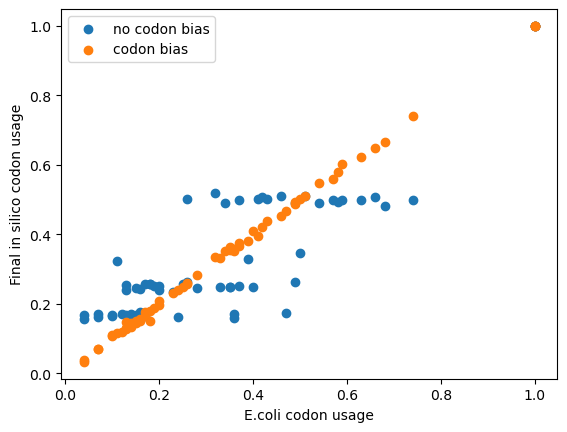

PyObject <matplotlib.legend.Legend object at 0x7f344ad1f670>

In [49]:
x = []
y1 = []
y2 = []
for a in keys(codon_usage)
    push!(x, codon_usage[a])
    push!(y1, cod_f[a])
    push!(y2, cod_f_cb[a])
end

plt.scatter(x, y1, label = "no codon bias")
plt.plot(x
plt.scatter(x, y2, label = "codon bias")
plt.xlabel("E.coli codon usage")
plt.ylabel("Final in silico codon usage")
plt.legend()

#plt.savefig("../codon_bias.png")

In [51]:
using JLD2
@save "../../data_codbias.jld2" x y1 y2